In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

In [2]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
aug_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/augmented_testing_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [3]:

# Convert Timestamp columns to datetime (very important for time operations)
for df in [aug_train, aug_test, org_train, org_test]:
    df['Timestamp'] = pd.to_datetime(df['Time'])

In [4]:
# =========================
# Lag + Rolling Feature Engineering

def generate_lag_and_rolling_features(df, lags_dict, rolling_windows):
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Timestamp')  # time sort within location
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

# =========================
# Lag + Rolling Feature Engineering (Timestamp → AugType → Location sorting)

def generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows):
    df = df.copy()
    
    # First sort globally by Timestamp, AugmentationType, then Location
    df = df.sort_values(['Timestamp', 'augmented', 'Location']).reset_index(drop=True)
    
    all_groups = []
    
    # Group by (AugmentationType, Location) — after global sorting
    for (aug_type, loc), group in df.groupby(['augmented', 'Location']):
        group = group.sort_values('Timestamp')  # ensure strict time order within each subgroup
        
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged




def add_time_features(df):
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['month'] = df['Timestamp'].dt.month
    
    df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def scale_features(df, scaler=None, feature_cols=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[feature_cols])
    else:
        scaled_values = scaler.transform(df[feature_cols])

    df_scaled = df.copy()
    df_scaled[feature_cols] = scaled_values
    return df_scaled, scaler

In [5]:
# =========================
# Complete Pipeline Function

def full_preprocessing_pipeline(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

# =========================
# Complete Pipeline Function for augmented data

def full_preprocessing_pipeline_for_aug(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

In [6]:
# =========================
# Setup lags and rolling windows

lags_dict = {
    'Power': [1, 3, 6, 12, 24],
    'windspeed_10m': [1, 3, 6, 24],
    'windspeed_100m': [1, 3, 6, 24],
    'windgusts_10m': [1, 3, 6, 24],
}

rolling_windows = [3, 6, 12, 24]

# =========================
# Apply pipeline

# ORIGINAL DATA
org_train_processed, org_scaler = full_preprocessing_pipeline(org_train, lags_dict, rolling_windows)
org_test_processed, _           = full_preprocessing_pipeline(org_test, lags_dict, rolling_windows)

# AUGMENTED DATA
aug_train_processed, aug_scaler = full_preprocessing_pipeline_for_aug(aug_train, lags_dict, rolling_windows)
# aug_test_processed, _           = full_preprocessing_pipeline_for_aug(aug_test, lags_dict, rolling_windows)

print("All datasets processed successfully!")


All datasets processed successfully!


In [7]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power_lag1', 'Power_lag3',
       'Power_lag6', 'Power_lag12', 'Power_lag24', 'windspeed_10m_lag1',
       'windspeed_10m_lag3', 'windspeed_10m_lag6', 'windspeed_10m_lag24',
       'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
       'windspeed_100m_lag24', 'windgusts_10m_lag1', 'windgusts_10m_lag3',
       'windgusts_10m_lag6', 'windgusts_10m_lag24', 'Power_roll_mean_3',
       'Power_roll_std_3', 'windspeed_10m_roll_mean_3',
       'windspeed_10m_roll_std_3', 'windspeed_100m_roll_mean_3',
       'windspeed_100m_roll_std_3', 'windgusts_10m_roll_mean_3',
       'windgusts_10m_roll_std_3', 'Power_roll_mean_6', 'Power_roll_std_6',
       'windspeed_10m_roll_mean_6', 'windspeed_10m_roll_std_6',
       'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6',
       'windgusts_10m_roll_mean_6', 'windgusts_10m_roll_std_6',
       'Power_roll_mean_12', 'Power_roll_std_12', 'windspeed_10m_roll_mean_12',
       'windspeed_10m_roll_std_12', 'windspeed_100m_roll_mean_12',
       'windspeed_100m_roll_std_12', 'windgusts_10m_roll_mean_12',
       'windgusts_10m_roll_std_12', 'Power_roll_mean_24', 'Power_roll_std_24',
       'windspeed_10m_roll_mean_24', 'windspeed_10m_roll_std_24',
       'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24',
       'windgusts_10m_roll_mean_24', 'windgusts_10m_roll_std_24'
]
target = 'Power'

In [8]:
X_train_org = org_train_processed[features]
y_train_org = org_train_processed[target]


y_test  =org_test_processed[target]
X_test = org_test_processed[features].copy()
X_test.index = pd.to_datetime(org_test_processed["Time"])

In [9]:
import torch
import torch.nn as nn
import numpy as np

# ------------------ TimesNet Model ------------------

class TimesBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), dilation=(1, dilation), padding=(0, dilation * (kernel_size - 1) // 2))
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.norm(out)
        out = self.relu(out)
        return out

class TimesNet(nn.Module):
    def __init__(self, input_len, forecast_len, num_features, hidden_channels=64, num_blocks=3, kernel_size=3):
        super().__init__()
        self.input_len = input_len
        self.forecast_len = forecast_len
        self.num_features = num_features

        self.blocks = nn.ModuleList()
        in_channels = 1

        for i in range(num_blocks):
            block = TimesBlock(in_channels, hidden_channels, kernel_size, dilation=2**i)
            self.blocks.append(block)
            in_channels = hidden_channels

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(hidden_channels, forecast_len)

    def forward(self, x):
        # Input shape: [Batch, Seq_len, Num_features]
        x = x.unsqueeze(1)  # [Batch, 1, Seq_len, Num_features] -> like an image
        for block in self.blocks:
            x = block(x)
        x = self.global_pool(x).squeeze(-1).squeeze(-1)
        out = self.fc(x)
        return out


In [10]:
# ------------------ Sequence Creation ------------------

def create_timesnet_multivariate_sequences(X_data, y_data, input_len, forecast_len):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - input_len - forecast_len + 1):
        X_seq.append(X_data[i:i+input_len])
        y_seq.append(y_data[i+input_len:i+input_len+forecast_len])
    return np.array(X_seq), np.array(y_seq)


In [11]:
# Desequencing Function
def desequence_forecasts(predictions, input_len, forecast_len):
    total_length = len(predictions) + input_len + forecast_len - 1
    merged_forecast = np.zeros(total_length)
    count = np.zeros(total_length)

    for i in range(len(predictions)):
        start = i + input_len
        end = start + forecast_len
        merged_forecast[start:end] += predictions[i]
        count[start:end] += 1

    nonzero_mask = count != 0
    merged_forecast[nonzero_mask] /= count[nonzero_mask]
    return merged_forecast


In [12]:
input_len = 24
forecast_len = 12
num_features = X_train_org.shape[1]


In [20]:
model_timesnet_org = TimesNet(input_len=input_len, forecast_len=forecast_len, num_features=num_features)
model_timesnet_no_shuffle = TimesNet(input_len=input_len, forecast_len=forecast_len, num_features=num_features)


In [22]:
# Load checkpoint
checkpoint_org = torch.load("../Models/weights/timesnet_org_shuffle.pth")
checkpoint_aug = torch.load("../Models/weights/timesnet_org.pth")

# Extract only the model state
model_timesnet_org.load_state_dict(checkpoint_org['model_state'])
model_timesnet_no_shuffle.load_state_dict(checkpoint_aug['model_state'])

<All keys matched successfully>

In [23]:
# ------------------ Desequencing ------------------

def desequence_forecasts(predictions, input_len, forecast_len):
    total_length = len(predictions) + input_len + forecast_len - 1
    merged_forecast = np.zeros(total_length)
    count = np.zeros(total_length)

    for i in range(len(predictions)):
        start = i + input_len
        end = start + forecast_len
        merged_forecast[start:end] += predictions[i]
        count[start:end] += 1

    nonzero_mask = count != 0
    merged_forecast[nonzero_mask] /= count[nonzero_mask]
    return merged_forecast

# ------------------ Evaluation ------------------

import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_timesnet_multivariate(model, scaler_X, scaler_y, X_test, y_test, input_len, forecast_len, time_index=None, start_point=0, end_point=None):
    X_test = X_test[start_point:end_point]
    y_test = y_test[start_point:end_point]

    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    X_seq, y_seq = create_timesnet_multivariate_sequences(X_test_scaled, y_test_scaled, input_len, forecast_len)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        preds_scaled = model(X_tensor).numpy()

    preds = scaler_y.inverse_transform(preds_scaled.reshape(-1, 1)).reshape(preds_scaled.shape)
    y_true = scaler_y.inverse_transform(y_seq.reshape(-1, 1)).reshape(y_seq.shape)

    merged_pred = desequence_forecasts(preds, input_len, forecast_len)
    merged_true = desequence_forecasts(y_true, input_len, forecast_len)

    merged_pred = merged_pred
    merged_true = merged_true

    mse = mean_squared_error(merged_true, merged_pred)
    mae = mean_absolute_error(merged_true, merged_pred)
    rmse = math.sqrt(mse)
    print(f"Test MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    if time_index is not None:
        valid_time_index = time_index[input_len+forecast_len:][:len(merged_pred)]
    else:
        valid_time_index = range(len(merged_pred))

    plt.figure(figsize=(16, 6))
    plt.plot(valid_time_index, merged_true, label="Actual", color="black")
    plt.plot(valid_time_index, merged_pred, label="Forecast", color="red", linestyle="--")
    plt.xlabel("Time" if time_index is not None else "Steps")
    plt.ylabel("Power")
    plt.title("TimesNet Forecast vs Actual")
    plt.legend()
    plt.grid(True)
    textstr = f'MAE: {mae:.4f}\nRMSE: {rmse:.4f}'
    plt.gcf().text(0.75, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()


In [24]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import torch
import numpy as np
import math

def evaluate_two_timesnet_models(
    model_org, model_aug,
    X_train_org, y_train_org,
    X_test, y_test,
    input_len, forecast_len,
    start_point=0, end_point=None
):
    # ----------------- Step 1: Scaling -----------------
    scaler_X = StandardScaler()
    scaler_X.fit(X_train_org)

    scaler_y = StandardScaler()
    scaler_y.fit(y_train_org.values.reshape(-1, 1))

    # ----------------- Step 2: Slice test set -----------------
    X_test = X_test[start_point:end_point].reset_index(drop=True)
    y_test = y_test[start_point:end_point].reset_index(drop=True)

    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    # ----------------- Step 3: Sequence creation -----------------
    X_seq, y_seq = create_timesnet_multivariate_sequences(X_test_scaled, y_test_scaled, input_len, forecast_len)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)

    # ----------------- Step 4: Prediction -----------------
    model_org.eval()
    model_aug.eval()
    with torch.no_grad():
        preds_org_scaled = model_org(X_tensor).numpy()
        preds_aug_scaled = model_aug(X_tensor).numpy()

    # ----------------- Step 5: Inverse scale predictions and targets -----------------
    preds_org = scaler_y.inverse_transform(preds_org_scaled.reshape(-1, 1)).reshape(preds_org_scaled.shape)
    preds_aug = scaler_y.inverse_transform(preds_aug_scaled.reshape(-1, 1)).reshape(preds_aug_scaled.shape)
    y_true = scaler_y.inverse_transform(y_seq.reshape(-1, 1)).reshape(y_seq.shape)

    # ----------------- Step 6: Desequencing -----------------
    merged_pred_org = desequence_forecasts(preds_org, input_len, forecast_len)
    merged_pred_aug = desequence_forecasts(preds_aug, input_len, forecast_len)
    merged_true = desequence_forecasts(y_true, input_len, forecast_len)

    # Align lengths
    min_len = min(len(merged_pred_org), len(merged_pred_aug), len(merged_true))
    merged_pred_org = merged_pred_org[:min_len]
    merged_pred_aug = merged_pred_aug[:min_len]
    merged_true = merged_true[:min_len]

    # ----------------- Step 7: Metrics -----------------
    mse_org = mean_squared_error(merged_true, merged_pred_org)
    mae_org = mean_absolute_error(merged_true, merged_pred_org)
    rmse_org = math.sqrt(mse_org)

    mse_aug = mean_squared_error(merged_true, merged_pred_aug)
    mae_aug = mean_absolute_error(merged_true, merged_pred_aug)
    rmse_aug = math.sqrt(mse_aug)

    print(f"[Shuffled]  MAE: {mae_org:.4f}, RMSE: {rmse_org:.4f}")
    print(f"[No Shuffled] MAE: {mae_aug:.4f}, RMSE: {rmse_aug:.4f}")

    # ----------------- Step 8: Plotting -----------------
    plot_range = range(min_len)

    plt.figure(figsize=(16, 6))
    plt.plot(plot_range, merged_true, label='Actual', color='black')
    plt.plot(plot_range, merged_pred_org, label='Shuffled Forecast', color='red', linestyle='--')
    plt.plot(plot_range, merged_pred_aug, label='No Shuffled Forecast', color='green', linestyle=':')

        # Shade between Actual and Shuffle Forecast (pink)
    plt.fill_between(plot_range, merged_true, merged_pred_org,
                     where=(merged_true >= merged_pred_org),
                     interpolate=True, color='pink', alpha=0.5, label='Error (Actual - Shuffle)')
    plt.fill_between(plot_range, merged_pred_org, merged_true,
                     where=(merged_true < merged_pred_org),
                     interpolate=True, color='pink', alpha=0.5)

    plt.fill_between(plot_range, merged_pred_org, merged_pred_aug,
                     where=(merged_pred_aug >= merged_pred_org),
                     interpolate=True, color='lightblue', alpha=0.5, label='Diff (Shuffle - No Shuffle)')
    plt.fill_between(plot_range, merged_pred_aug, merged_pred_org,
                     where=(merged_pred_aug < merged_pred_org),
                     interpolate=True, color='lightblue', alpha=0.5)

    plt.xlabel("Steps")
    plt.ylabel("Power")
    plt.title("TimesNet Forecast Comparison: Shuffled vs No Shuffled")
    plt.legend()
    plt.grid(True)

    textstr = (
        f'Shuffled Model\nMAE: {mae_org:.4f}\nRMSE: {rmse_org:.4f}\n'
        f'No Shuffled Model\nMAE: {mae_aug:.4f}\nRMSE: {rmse_aug:.4f}'
    )
    plt.gcf().text(0.75, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    # plt.show()

    #     # --- Inset Zoom Plot ---
    # # Define zoom window (adjust indices for a peak region)
    # zoom_start, zoom_end = 200, 300

    # ax_main = plt.gca()
    # ax_inset = inset_axes(ax_main, width="30%", height="40%", loc='upper left', borderpad=3)
    # ax_inset.plot(range(zoom_start, zoom_end), merged_true[zoom_start:zoom_end], color='black')
    # ax_inset.plot(range(zoom_start, zoom_end), merged_pred_org[zoom_start:zoom_end], color='red', linestyle='--')
    # ax_inset.plot(range(zoom_start, zoom_end), merged_pred_aug[zoom_start:zoom_end], color='green', linestyle=':')

    # ax_inset.set_title("Zoomed-In View")
    # ax_inset.grid(True)
    # ax_inset.tick_params(axis='both', labelsize=8)

    # mark_inset(ax_main, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5")

    plt.show()

    return {
        'Shuffled': {'MAE': mae_org, 'RMSE': rmse_org},
        'No Shuffled': {'MAE': mae_aug, 'RMSE': rmse_aug}
    }


[Shuffled]  MAE: 0.2465, RMSE: 0.3036
[No Shuffled] MAE: 0.2706, RMSE: 0.3362


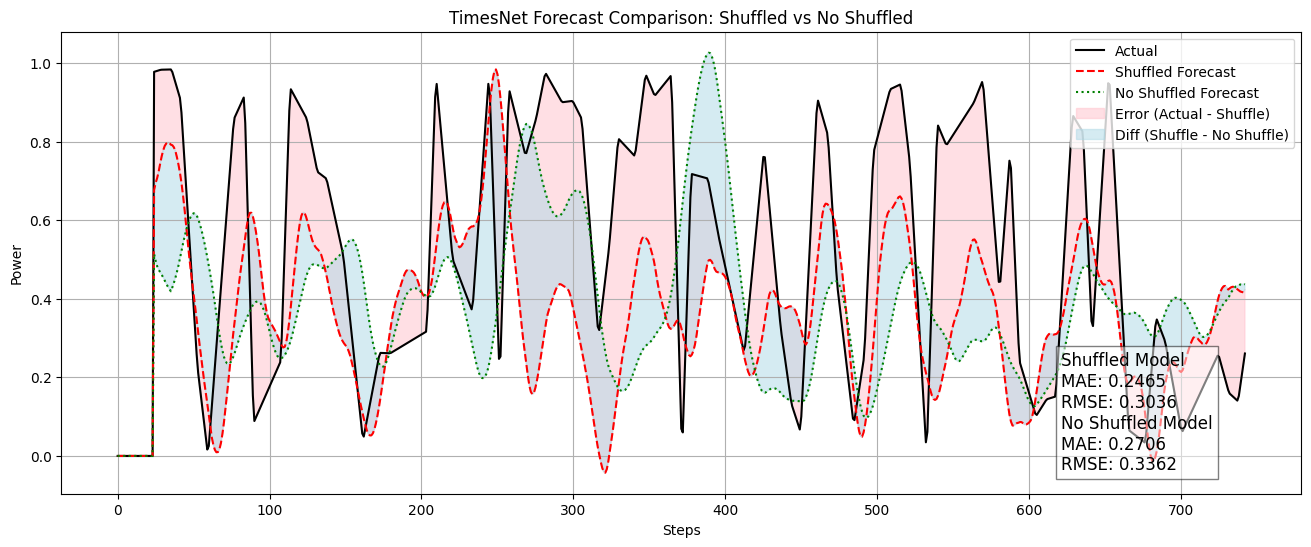

[Shuffled]  MAE: 0.1405, RMSE: 0.1876
[No Shuffled] MAE: 0.1805, RMSE: 0.2218


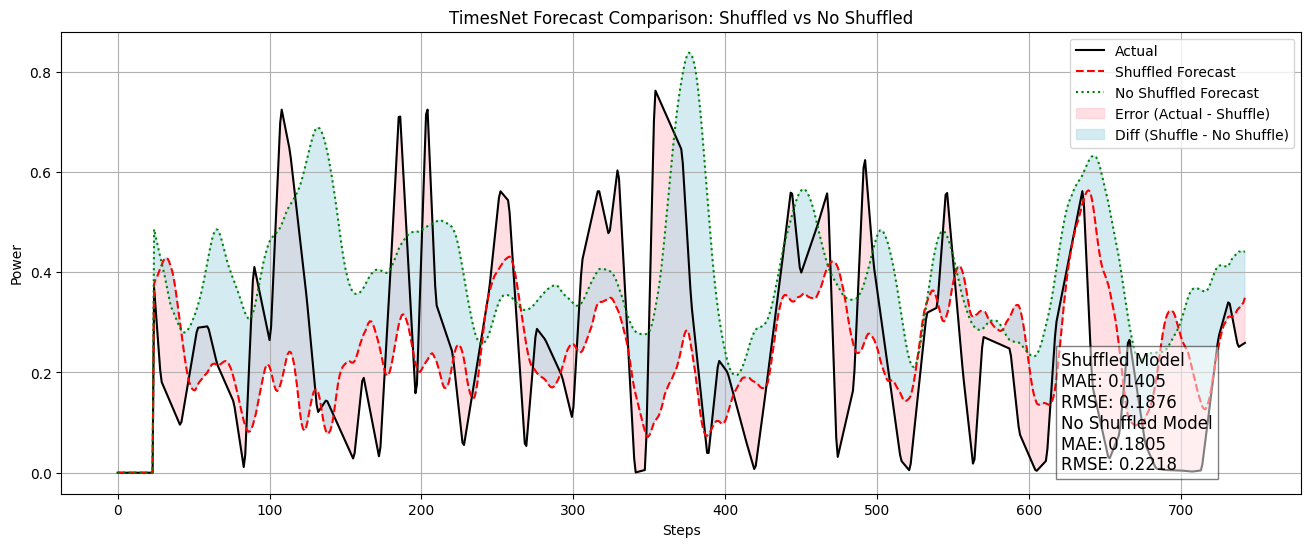

[Shuffled]  MAE: 0.2940, RMSE: 0.3598
[No Shuffled] MAE: 0.3200, RMSE: 0.3848


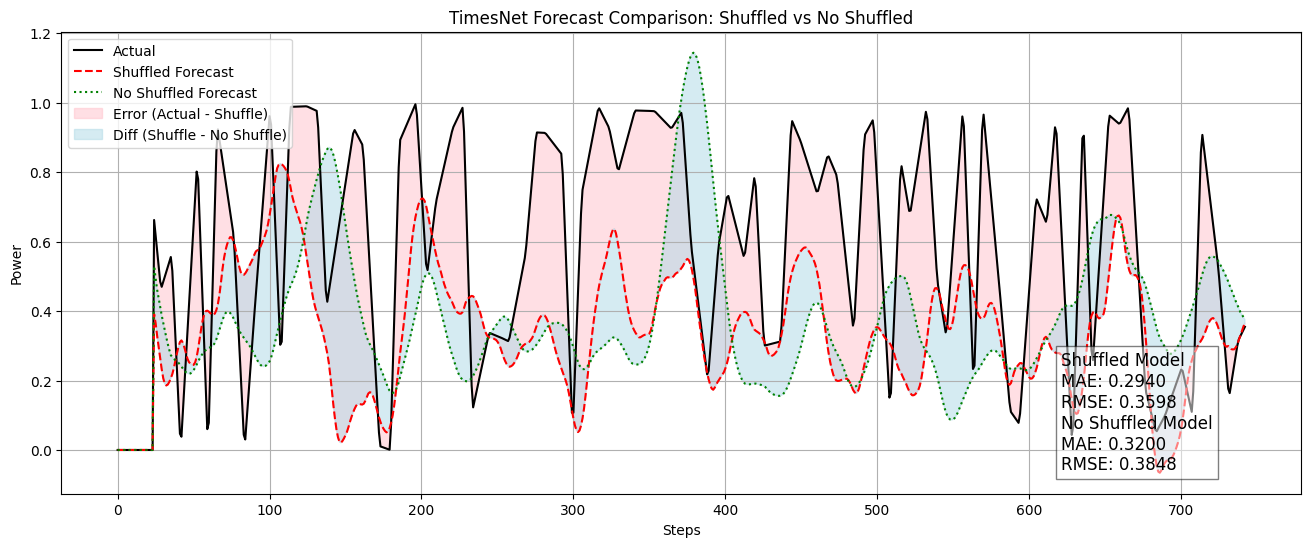

[Shuffled]  MAE: 0.1750, RMSE: 0.2134
[No Shuffled] MAE: 0.2093, RMSE: 0.2586


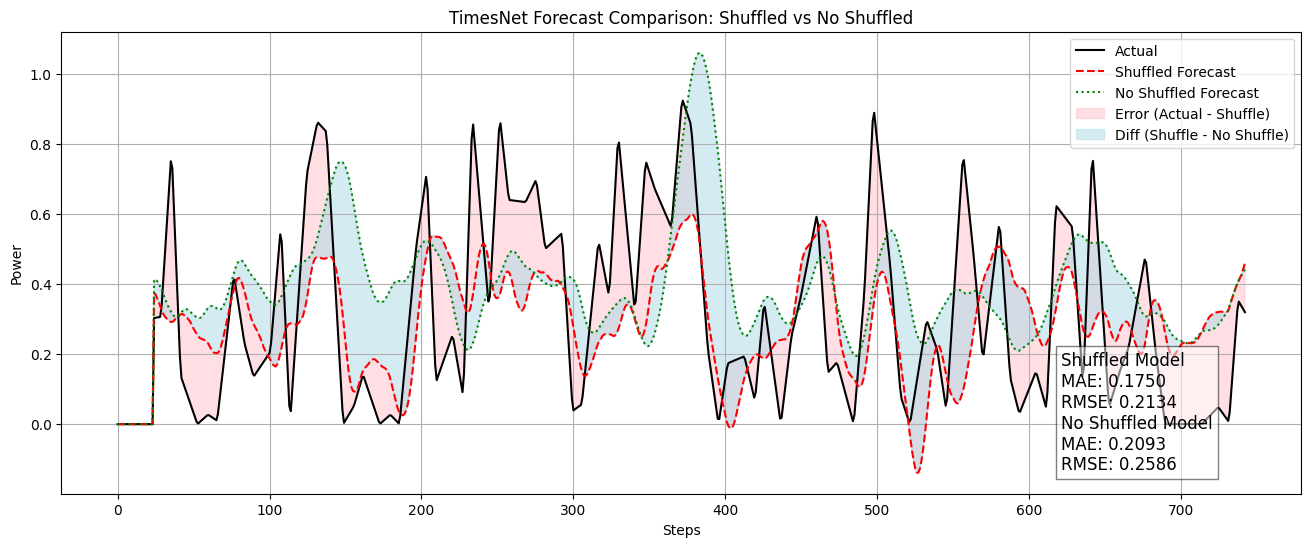

In [30]:
results = evaluate_two_timesnet_models(
    model_org=model_timesnet_org,
    model_aug=model_timesnet_no_shuffle,
    X_train_org=X_train_org,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    input_len=24,
    forecast_len=12,
    start_point=7991, 
    end_point=8734
)

results_1 = evaluate_two_timesnet_models(
    model_org=model_timesnet_org,
    model_aug=model_timesnet_no_shuffle,
    X_train_org=X_train_org,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    input_len=24,
    forecast_len=12,
   start_point=16726, 
   end_point=17469
)

results_2 = evaluate_two_timesnet_models(
    model_org=model_timesnet_org,
    model_aug=model_timesnet_no_shuffle,
    X_train_org=X_train_org,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    input_len=24,
    forecast_len=12,
    start_point=25461, 
    end_point=26204
)

results_3 = evaluate_two_timesnet_models(
    model_org=model_timesnet_org,
    model_aug=model_timesnet_no_shuffle,
    X_train_org=X_train_org,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    input_len=24,
    forecast_len=12,
    start_point=34196, 
    end_point=34939
)

In [32]:
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import torch
import math

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask):
        return np.nan  # All true values are zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.abs(y_true - y_pred) / np.clip(denominator, 1e-8, None)) * 100

def evaluate_monthly_timesnet_errors(
    model_org, model_aug,
    X_train_org, y_train_org,
    X_test, y_test,
    input_len, forecast_len
):
    # Ensure datetime index
    X_test = X_test.copy()
    X_test.index = pd.to_datetime(X_test.index)
    y_test.index = X_test.index

    # Scale features and targets
    scaler_X = StandardScaler().fit(X_train_org)
    scaler_y = StandardScaler().fit(y_train_org.values.reshape(-1, 1))
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    n_locations = 4
    loc_size = len(X_test) // n_locations
    results = []

    for loc in range(n_locations):
        start, end = loc * loc_size, (loc + 1) * loc_size
        X_loc = X_test_scaled[start:end]
        y_loc = y_test_scaled[start:end]
        time_loc = X_test.index[start:end]

        df_loc = pd.DataFrame(X_loc, index=time_loc)
        df_loc['target'] = y_loc

        for month, df_month in df_loc.groupby(pd.Grouper(freq='M')):
            if len(df_month) < input_len + forecast_len:
                continue

            X_month = df_month.drop(columns='target').values
            y_month = df_month['target'].values

            X_seq, y_seq = create_timesnet_multivariate_sequences(X_month, y_month, input_len, forecast_len)
            if len(X_seq) == 0:
                continue

            X_tensor = torch.tensor(X_seq, dtype=torch.float32)

            with torch.no_grad():
                model_org.eval()
                model_aug.eval()
                preds_org_scaled = model_org(X_tensor).numpy()
                preds_aug_scaled = model_aug(X_tensor).numpy()

            preds_org = scaler_y.inverse_transform(preds_org_scaled.reshape(-1, 1)).reshape(preds_org_scaled.shape)
            preds_aug = scaler_y.inverse_transform(preds_aug_scaled.reshape(-1, 1)).reshape(preds_aug_scaled.shape)
            y_true = scaler_y.inverse_transform(y_seq.reshape(-1, 1)).reshape(y_seq.shape)

            merged_pred_org = desequence_forecasts(preds_org, input_len, forecast_len)
            merged_pred_aug = desequence_forecasts(preds_aug, input_len, forecast_len)
            merged_true = desequence_forecasts(y_true, input_len, forecast_len)

            min_len = min(len(merged_pred_org), len(merged_pred_aug), len(merged_true))
            merged_pred_org = merged_pred_org[:min_len]
            merged_pred_aug = merged_pred_aug[:min_len]
            merged_true = merged_true[:min_len]

            # --- Metrics ---
            results.append({
                'location': f'Location_{loc+1}',
                'month': month.strftime('%Y-%m'),
                'mae_shuffle': mean_absolute_error(merged_true, merged_pred_org),
                'rmse_shuffle': math.sqrt(mean_squared_error(merged_true, merged_pred_org)),
                'mape_shuffle': mape(merged_true, merged_pred_org),
                'smape_shuffle': smape(merged_true, merged_pred_org),
                'r2_shuffle': r2_score(merged_true, merged_pred_org),
                'mae_no_shuffle': mean_absolute_error(merged_true, merged_pred_aug),
                'rmse_no_shuffle': math.sqrt(mean_squared_error(merged_true, merged_pred_aug)),
                'mape_no_shuffle': mape(merged_true, merged_pred_aug),
                'smape_no_shuffle': smape(merged_true, merged_pred_aug),
                'r2_no_shuffle': r2_score(merged_true, merged_pred_aug),
            })

    results_df = pd.DataFrame(results)

    # Monthly summary across all locations
    monthly_summary = results_df.groupby('month').agg({
        'mae_shuffle': ['mean', 'std'],
        'rmse_shuffle': ['mean', 'std'],
        'mape_shuffle': ['mean', 'std'],
        'smape_shuffle': ['mean', 'std'],
        'r2_shuffle': ['mean', 'std'],
        'mae_no_shuffle': ['mean', 'std'],
        'rmse_no_shuffle': ['mean', 'std'],
        'mape_no_shuffle': ['mean', 'std'],
        'smape_no_shuffle': ['mean', 'std'],
        'r2_no_shuffle': ['mean', 'std'],
    }).reset_index()

    monthly_summary.columns = ['month'] + [f"{col[0]}_{col[1]}" for col in monthly_summary.columns[1:]]
    return results_df, monthly_summary


In [33]:
results_df, monthly_summary = evaluate_monthly_timesnet_errors(
    model_org=model_timesnet_org,
    model_aug=model_timesnet_no_shuffle,
    X_train_org=X_train_org,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    input_len=24,
    forecast_len=12
)


/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_7736/930884439.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in df_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_7736/930884439.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in df_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_7736/930884439.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in df_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_7736/930884439.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in df_loc.groupby(pd.Grouper(freq='M')):


In [34]:
final_results = []

for loc in results_df['location'].unique():
    loc_data = results_df[results_df['location'] == loc]
    final_results.append({
        'Location': loc,
        'mae_shuffle': f"{loc_data['mae_shuffle'].mean():.4f}  ± {loc_data['mae_shuffle'].std():.4f}",
        'rmse_shuffle': f"{loc_data['rmse_shuffle'].mean():.4f}  ± {loc_data['rmse_shuffle'].std():.4f}",
        'mape_shuffle': f"{loc_data['mape_shuffle'].mean():.4f}  ± {loc_data['mape_shuffle'].std():.4f}",
        'smape_shuffle': f"{loc_data['smape_shuffle'].mean():.4f}  ± {loc_data['smape_shuffle'].std():.4f}",
        'r2_shuffle': f"{loc_data['r2_shuffle'].mean():.4f}  ± {loc_data['r2_shuffle'].std():.4f}",
        'mae_no_shuffle': f"{loc_data['mae_no_shuffle'].mean():.4f}  ± {loc_data['mae_no_shuffle'].std():.4f}",
        'rmse_no_shuffle': f"{loc_data['rmse_no_shuffle'].mean():.4f}  ± {loc_data['rmse_no_shuffle'].std():.4f}",
        'mape_no_shuffle': f"{loc_data['mape_no_shuffle'].mean():.4f}  ± {loc_data['mape_no_shuffle'].std():.4f}",
        'smape_no_shuffle': f"{loc_data['smape_no_shuffle'].mean():.4f}  ± {loc_data['smape_no_shuffle'].std():.4f}",
        'r2_no_shuffle': f"{loc_data['r2_no_shuffle'].mean():.4f}  ± {loc_data['r2_no_shuffle'].std():.4f}",
    })

final_results.append({
    'Location': 'All Location Combined',
    'mae_shuffle': f"{results_df['mae_shuffle'].mean():.4f}  ± {results_df['mae_shuffle'].std():.4f}",
    'rmse_shuffle': f"{results_df['rmse_shuffle'].mean():.4f}  ± {results_df['rmse_shuffle'].std():.4f}",
    'mape_shuffle': f"{results_df['mape_shuffle'].mean():.4f}  ± {results_df['mape_shuffle'].std():.4f}",
    'smape_shuffle': f"{results_df['smape_shuffle'].mean():.4f}  ± {results_df['smape_shuffle'].std():.4f}",
    'r2_shuffle': f"{results_df['r2_shuffle'].mean():.4f}  ± {results_df['r2_shuffle'].std():.4f}",
    'mae_no_shuffle': f"{results_df['mae_no_shuffle'].mean():.4f}  ± {results_df['mae_no_shuffle'].std():.4f}",
    'rmse_no_shuffle': f"{results_df['rmse_no_shuffle'].mean():.4f}  ± {results_df['rmse_no_shuffle'].std():.4f}",
    'mape_no_shuffle': f"{results_df['mape_no_shuffle'].mean():.4f}  ± {results_df['mape_no_shuffle'].std():.4f}",
    'smape_no_shuffle': f"{results_df['smape_no_shuffle'].mean():.4f}  ± {results_df['smape_no_shuffle'].std():.4f}",
    'r2_no_shuffle': f"{results_df['r2_no_shuffle'].mean():.4f}  ± {results_df['r2_no_shuffle'].std():.4f}",
})
final_results =  pd.DataFrame(final_results)

In [35]:
final_results =  pd.DataFrame(final_results)

In [36]:
final_results

,Location,mae_shuffle,rmse_shuffle,mape_shuffle,smape_shuffle,r2_shuffle,mae_no_shuffle,rmse_no_shuffle,mape_no_shuffle,smape_no_shuffle,r2_no_shuffle
0,Location_1,0.1960 ± 0.0461,0.2478 ± 0.0549,450.5470 ± 705.2370,62.3579 ± 10.1005,0.2145 ± 0.1859,0.2449 ± 0.0374,0.3023 ± 0.0467,592.2208 ± 942.2189,74.0150 ± 13.1789,-0.1838 ± 0.2290
1,Location_2,0.1335 ± 0.0242,0.1733 ± 0.0325,481.1634 ± 263.5291,95.2583 ± 20.3425,-0.1244 ± 0.3565,0.2419 ± 0.0385,0.2839 ± 0.0374,1723.7925 ± 1049.8876,99.1196 ± 22.7894,-2.4845 ± 2.1318
2,Location_3,0.1699 ± 0.0833,0.2110 ± 0.0987,1686.3388 ± 2589.5881,105.1097 ± 32.1865,-1.9255 ± 5.0397,0.2944 ± 0.0612,0.3370 ± 0.0611,4817.3536 ± 5975.4219,111.9888 ± 36.5493,-30.2640 ± 86.7148
3,Location_4,0.1374 ± 0.0382,0.1807 ± 0.0446,940.1727 ± 854.0343,76.8961 ± 12.0913,0.2107 ± 0.2139,0.2172 ± 0.0400,0.2542 ± 0.0404,2451.8568 ± 1934.1686,86.4519 ± 17.6359,-0.9600 ± 1.6352
4,All Location Combined,0.1592 ± 0.0571,0.2032 ± 0.0677,889.5555 ± 1458.5543,84.9055 ± 25.9841,-0.4062 ± 2.6073,0.2496 ± 0.0522,0.2943 ± 0.0549,2396.3059 ± 3484.5023,92.8938 ± 27.4267,-8.4731 ± 43.8625


In [37]:
monthly_summary

,month,mae_shuffle_mean,mae_shuffle_std,rmse_shuffle_mean,rmse_shuffle_std,mape_shuffle_mean,mape_shuffle_std,smape_shuffle_mean,smape_shuffle_std,r2_shuffle_mean,...,mae_no_shuffle_mean,mae_no_shuffle_std,rmse_no_shuffle_mean,rmse_no_shuffle_std,mape_no_shuffle_mean,mape_no_shuffle_std,smape_no_shuffle_mean,smape_no_shuffle_std,r2_no_shuffle_mean,r2_no_shuffle_std
0,2021-01,0.168159,0.045827,0.210074,0.055083,1293.895933,1075.714552,96.488957,20.610727,-0.136147,...,0.235982,0.030523,0.285462,0.033715,4560.379459,4009.011221,97.954251,25.101681,-1.863271,3.017561
1,2021-02,0.166135,0.066519,0.213274,0.083363,1386.988993,1710.439562,87.279425,27.062470,-0.113595,...,0.232892,0.044704,0.281383,0.056224,2645.071235,3045.048466,92.215884,29.634734,-1.760025,2.464538
2,2021-03,0.186113,0.071890,0.231792,0.088419,2551.546984,4365.100374,89.856276,34.512353,-0.068969,...,0.286637,0.021480,0.330600,0.027181,6913.432031,9376.272965,97.929517,30.185918,-1.896912,1.980027
3,2021-04,0.153913,0.029808,0.201116,0.038517,407.773910,349.837689,82.182110,27.041909,-0.001770,...,0.208826,0.036188,0.262890,0.052357,1093.567486,1106.140594,79.491427,15.810758,-0.766720,0.699808
4,2021-05,0.124554,0.017171,0.168596,0.027893,908.816665,1024.902325,83.782602,28.758218,-0.031445,...,0.244742,0.033496,0.285119,0.025677,3039.965471,3370.918765,96.004653,26.255566,-3.042526,4.576595
5,2021-06,0.125059,0.026548,0.167106,0.039872,852.450269,1134.158923,100.606893,39.194162,-0.430494,...,0.294238,0.056687,0.328803,0.049857,2550.839374,2100.313938,119.710076,36.924028,-8.882531,13.730488
6,2021-07,0.104989,0.025915,0.135411,0.034411,556.195186,429.737021,98.446337,47.257337,-4.361077,...,0.257139,0.092089,0.288143,0.083137,2017.161958,2099.488871,114.218330,49.639914,-77.784125,151.059005
7,2021-08,0.125269,0.019800,0.159056,0.025962,1055.992569,789.904839,96.697486,13.175267,-0.201633,...,0.257519,0.033961,0.289360,0.031088,2427.466287,922.000483,110.074320,16.134547,-4.068436,4.366528
8,2021-09,0.153149,0.024972,0.196950,0.030117,437.921729,206.766971,79.161183,16.836612,0.131633,...,0.214716,0.028488,0.256519,0.027441,810.473184,385.786296,82.851682,12.915062,-0.565240,0.837140
9,2021-10,0.172772,0.061590,0.222899,0.077567,845.804199,729.627941,76.172227,5.852625,0.310682,...,0.248045,0.043433,0.295109,0.055618,2016.579044,1731.253984,87.417529,8.063539,-0.278929,0.342082


In [38]:
FOLDER_NAME = './Results/TimesNet'
os.makedirs(FOLDER_NAME, exist_ok=True)
final_results.to_csv(os.path.join(FOLDER_NAME,"final_results.csv"), index=False)
monthly_summary.to_csv(os.path.join(FOLDER_NAME,"monthly_summary.csv"), index=False)